# Introduction

Time series classification is a common task, having many applications in numerous domains like IOT (Internet of things), signal processing, human activity recognition and so on. The goal is to train a model that can accurately predict the class of a time series, given a dataset with labeled time sequences.

A popular approach to tackle this problem is to use the K-Nearest Neighbors algorithm, but instead of using the classic Euclidean distance, the implementation is adapted to utilize the Dynamic Time Warping (DTW) metric. DTW takes into consideration the fact that the two time series being compared may vary in length and speed.

This approach, while simple and efficient in practice, is in fact quite elusive, something which is mainly attributed to the DTW. The most common beginner mistake is to perform hyperparameter tuning on the KNN and completely overlook the DTW part. The main disadvantage of DTW is time complexity: for large datasets with lengthy sequences, it may be impossible to train the model in reasonable time. Fortunately, by understanding the underlying notion of DTW, it is possible to perform the necessary tweaks in order to significantly speed up the algorithm.

# DTW: How it works

As a starter example, we will use the dtaidistance library and compute the distance between 2 phase-shifted sine waves:

In [1]:
# Imports

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = np.arange(0, 20, .5)
s1 = np.sin(x)
s2 = np.sin(x - 1)

In [3]:
path = dtw.warping_path(s1, s2)

In [4]:
path

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (3, 5),
 (4, 6),
 (5, 7),
 (6, 8),
 (7, 9),
 (8, 10),
 (9, 11),
 (10, 12),
 (11, 13),
 (12, 14),
 (13, 15),
 (14, 16),
 (15, 17),
 (16, 18),
 (17, 19),
 (18, 20),
 (19, 21),
 (20, 22),
 (21, 23),
 (22, 24),
 (23, 25),
 (24, 26),
 (25, 27),
 (26, 28),
 (27, 29),
 (28, 30),
 (29, 31),
 (30, 32),
 (31, 33),
 (32, 34),
 (33, 35),
 (34, 36),
 (35, 37),
 (36, 38),
 (37, 39),
 (38, 39),
 (39, 39)]

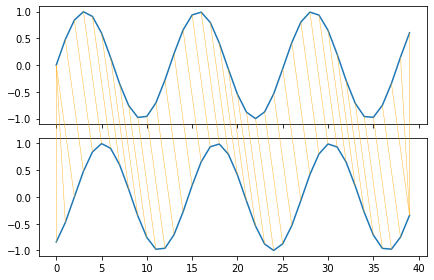

In [5]:
dtwvis.plot_warping(s1, s2, path);

In [6]:
distance = dtw.distance(s1, s2)
distance

1.4419019877541719

Figure 1 shows the optimal distances between all points of the 2 sine waves. We can also plot the dynamic programming matrix (or accumulated cost matrix) which shows all the warping paths. This is shown in Figure 2:

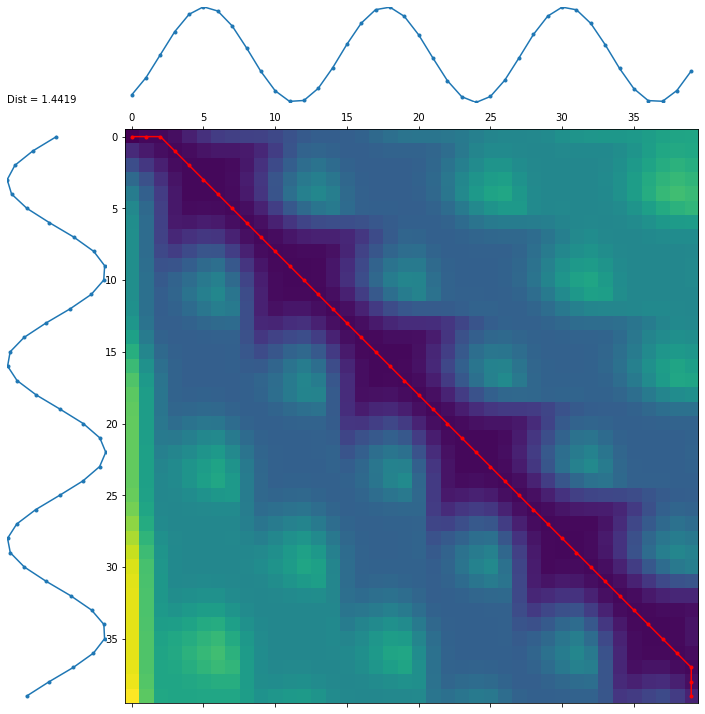

In [7]:
d, paths = dtw.warping_paths(s1, s2)
dtwvis.plot_warpingpaths(s1, s2, paths);

Each cell in Figure 2 is actually a number, representing the distance between the 2 respective data points being compared, one for each sequence. The darker the color, the lower the distance. After constructing the matrix, the optimal warping path is extracted (red line).

On the other hand, the time complexity is O(M,N) where M,N are the lengths of the respective sequences -a quadratic cost! Considering that the sequences may be large (not uncommon in real-world examples) as well as the fact that KNN would still have to run afterwards, it is very likely that the model may take too long to get trained.

Fortunately, now that we know how DTW works as well as the context of the problem, it is possible to optimize the total execution. One key observation in Figure 2, is that the optimal warping path mostly follows the main diagonal. This happens in most cases. For a cell in row i, as the index moves through columns j further from the diagonal, the cost starts to rack up. Intuitively, it is highly unlikely that a massive phase-shift exists in a real world dataset. As part of dataset exploration, one could also extract important frequencies with Fourier Transform and make sure there is not any problem.

The aforementioned library via the `window` argument gives us this capability. We also add `use_pruning=True` :

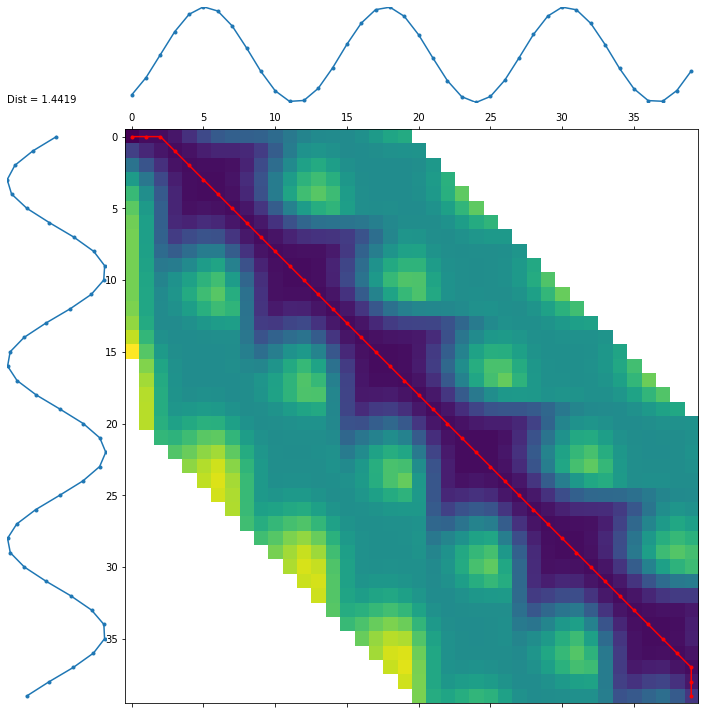

In [8]:
d, paths = dtw.warping_paths(s1, s2, window=20, use_pruning=True)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path);

The blank cells in Figure 3 are skipped by the algorithm because the maximum shift is 20. To better demonstrate this optimisation though, we will use a real dataset.

# Real case scenario

We will use the popular HAR (Human activity recognition) dataset from UCI, which contains labeled time series. Specifically, an instance of this dataset is a person wearing a smartphone which captures the linear acceleration and angle velocity while performing one of the following activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING). Therefore, each observation is a 561-feature vector with time/frequency domain variables and a label describing the person’s activity, and the goal is to build a model that accurately predicts the activity using the transformed feed from the smartphone.

In [9]:
x_train_file = open(r'UCI HAR Dataset/train/X_train.txt', 'r')
y_train_file = open(r'UCI HAR Dataset/train/y_train.txt', 'r')
x_test_file = open(r'UCI HAR Dataset/test/X_test.txt', 'r')
y_test_file = open(r'UCI HAR Dataset/test/y_test.txt', 'r')

In [10]:
# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1: 'WALKING', 2: 'WALKING UPSTAIRS', 3: 'WALKING DOWNSTAIRS',
          4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))

In [11]:
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

In [12]:
x_train.shape

(7352, 561)

In [13]:
y_train.shape

(7352,)

In [14]:
x_test.shape

(2947, 561)

In [15]:
y_test.shape

(2947,)

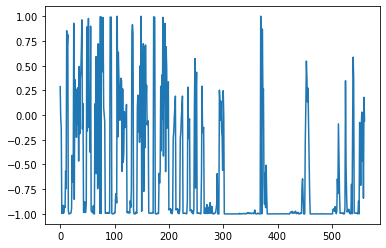

In [16]:
plt.figure()
plt.plot(x_train[0])
plt.show();

Let’s calculate the time it takes to compute the distance between the first time series of the train set and all of the series in the test set:

In [17]:
# %%time
# idx=0
# for r in range(len(x_test)):
#     distance = dtw.distance(x_train[idx], x_test[r], window=20, use_pruning='True')
# #Output
# Wall time: 1min 42s

# for r in range(len(x_test)):
#     distance = dtw.distance(x_train[idx], x_test[r])
# #Output
# Wall time: 25min 16s

Obviously, the speedup is significant! Finally, we conclude the example by applying the KNN algorithm. All of the above examples use `k`=20 for the KNN and `window` size=20 for the DTW function. The `idx` variable is simply the index of the time series in the test set:

In [18]:
# function that takes as input the number of neigbors of KNN and the index of 
# the time series in the test set, and returns one of the labels: 
# WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING

def classifyNN(k: int, idx: int) -> str:
    
    idxs = range(0, x_train.shape[0])
    n = x_train.shape[0]
    distances = []
    counters = {}
    c = 1
    max_value = 0
    
    for i in range(n):
        distances.append(
            dtw.distance(x_test[idx], x_train[idxs[i]], window=10, use_pruning=True)
        )
        # NN = the indices of the x_train that has the smallest distance with x_test[idx]
    NN = sorted(
        range(len(distances)), key=lambda x: distances[x], reverse=False
    )[:k]
    
    for label in labels.values():
        counters[label] = 0
    for r in NN:
        label = labels[y_train[r]]
        counters[label] += 1
        if (counters[label]) > max_value:
            max_value = counters[label]
        #print('NN(%d) has label %s' % (c,l))
        c += 1
    
    # find the label(s) with the highest frequency
    keys = [k for k in counters if counters[k] == max_value]
    
    # in case of a tie, return one at random
    return (random.sample(keys, 1)[0])

Then, we test a few cases:

# **Example 1:** Class ‘Standing’

In [19]:
labels[y_test[3]]

'STANDING'

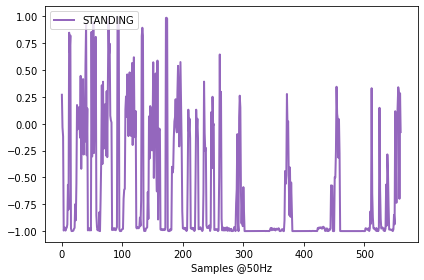

In [20]:
k = 20
idx = 3
plt.plot(x_test[idx], label=labels[y_test[idx]], color=colors[y_test[idx]-1], linewidth=2)
plt.xlabel('Samples @50Hz')
plt.legend(loc='upper left')
plt.tight_layout()

In [21]:
%%time
classifyNN(k, idx)

CPU times: total: 2min 25s
Wall time: 2min 25s


'STANDING'

# **Example 2:** Class ‘Sitting’

In [22]:
labels[y_test[200]]

'SITTING'

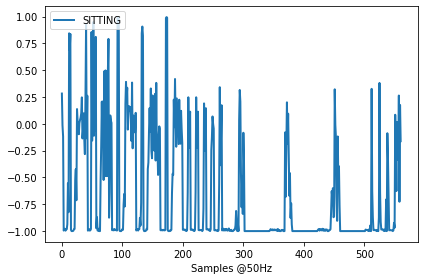

In [23]:
k = 20
idx = 200
plt.plot(x_test[idx], label=labels[y_test[idx]], color=colors[y_test[idx]-1], linewidth=2)
plt.xlabel('Samples @50Hz')
plt.legend(loc='upper left')
plt.tight_layout()

In [24]:
%%time
classifyNN(k, idx)

CPU times: total: 2min 31s
Wall time: 2min 32s


'STANDING'

# **Example 3:** Class ‘Walking’

In [25]:
labels[y_test[401]]

'WALKING'

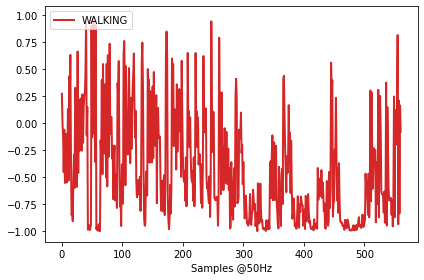

In [26]:
k = 20
idx = 401
plt.plot(x_test[idx], label=labels[y_test[idx]], color=colors[y_test[idx]-1], linewidth=2)
plt.xlabel('Samples @50Hz')
plt.legend(loc='upper left')
plt.tight_layout()

In [27]:
%%time
classifyNN(k, idx)

CPU times: total: 2min 25s
Wall time: 2min 25s


'WALKING'

Evidently, all examples were correctly classified. In general, the algorithm performs very well. It is worth mentioning that if we hadn’t add the window argument which enables pruning, the model would take days to train! (Change the window argument inside the classifyNN() function and see for yourself)

# What about parallelisation?

The next thing that comes to mind is if it’s possible to further speed up the execution of DTW by applying **parallelisation**. Unfortunately, with the current form of DTW it is quite tricky, however there are a few other implementations where by applying some modifications to the algorithm, the time complexity come even become linear. These implementations do not always provide the optimal solution though. On the other hand, it is possible to speed up the execution as a whole by calculating the **DTW pairwise distances of all time-series in a dataset in parallel**. This would be also extremely helpful when we want to construct a distance matrix fast. As you might have guessed by now, this technique finds application in time-series clustering by employing **hierarchical clustering**.The `dtaidistance` library contains the function `distance_matrix_fast( list of sequences)` which returns a distance matrix and runs in parallel.

# Closing remarks

The combination of DTW with KNN is pretty effective for time series classification. There is a caveat though regarding time complexity, but we have shown how to optimize the search space and speed up the execution. Apart from classification, DTW is also used as a distance metric when applying clustering in time series, so it is imperative to know how this technique works. Finally, regarding classification, there are other algorithms in this domain, like Time Series Forest Classifier which are mostly used when explainability is required (feature importances extraction, like Random Forest).